# Docker BRATS results

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import os
import seaborn as sb
import math
import pickle
from pprint import pprint
from nltk import agreement
from sklearn.metrics import cohen_kappa_score
%matplotlib inline

In [134]:
# set up the variables and environment
met = 'wt'
# stupid switch for dumb experiments to make data pretty
stupid = False

#set baseline variables for export and stuff
res = 400 # dpi value for image export
form = 'png' #image format for matplotlib exports
filename = met + '_dice_scores.csv'
#rename colums to their 3 character IDs
candidates = {
        'aju' : 'tumor_istb_aj_class.nii',
        'aca' : 'data_data_prediction.nii.gz',
        'kch' : 'tumor_qtimlab_class.nii.gz',
        'ekr' : 'tumor_00000000_class.nii.gz',
        'aka' : 'tumor_kamleshp_class.nii.gz',
        'mag' : 'tumor_magnrbm_class.nii',
        'sse' : 'tumor_saras_tb_class.nii.gz',
        'rsa': 'tumor_gevaertlab_class.nii',
        'gwa' : 'brats_dc_brats2016_test_klhd_pat101_3.nii.gz',
        'ise' : 'tumor_brats2017_isensee_class.nii.gz',
        'mav' : 'majvote_fusion.nii.gz',
        'sim' : 'simple_fusion.nii.gz',
        'sim2': 'simple2_fusion.nii.gz',
        'none' : 'default'
    }

sseRep = {
    'brats2016_test_cbica_patAMQ_362' : 0,
    'brats2016_test_tcia_pat457_0079' : 0,
    'brats2016_test_cbica_patAOQ1_1' : 0
}
#invert the indices to assign the proper labels
inv_cand = {v: k for k, v in candidates.items()}

irrScores = {}

In [135]:
#import data
data = pandas.read_csv(filename)
#data

In [136]:
#preprocess data
def preprocessor(data, met):
    # remove every 2nd row (unnecessary column heads)
    clean = data.replace({'tumor_saras_tb_class.nii.gz' : sseRep})
    clean = clean.iloc[::2]
    # remove patient name column
    # clean = clean.drop('patient', axis=1)
    # rename columns to 3 digit ID
    clean = clean.rename(inv_cand, axis=1)
    # store csv
    #clean.reset_index(inplace=True)
    #print(clean)
    clean.to_csv(met+'_clean.csv')
    # read a clean copy of the preprocessed csv again
    data = pandas.read_csv('fixed_data/'+met+'_clean.csv')
    # remove wrong row indices
    data = data.drop('Unnamed: 0', axis=1)
    return data

In [137]:
data = preprocessor(data, met)
# read a clean copy of the preprocessed csv again
# data = pandas.read_csv(met+'_clean.csv')
# remove wrong row indices
# data = data.drop('Unnamed: 0', axis=1)

### Inter Rater Reliability

In [138]:
# IRR function using the Cohen Kappa Score 
# https://en.wikipedia.org/wiki/Cohen%27s_kappa
# create empty dataframe for correlation indices

def irr(data, res, base=5):
    """ Data is the Dataframe with the initial data
    irr is an empty DataFrame with matching columns and indices
    (nxn matrix of n columns) for the resulting scores
    base is the class interval size (default: 5)
    """
    for r1 in data:
        if r1 != 'patient':
            # convert continuous values to integer classes
            rater1 = (data[r1].round(decimals=2)*100).tolist()
            rater1 = list(map(int, rater1))
            rater1 = [base*math.floor(x/base) for x in rater1]
        for r2 in data:
            if r2 != 'patient':
                rater2 = (data[r2].round(decimals=2)*100).tolist()
                rater2 = list(map(int, rater2))
                rater2 = [base*math.floor(x/base) for x in rater2]
                # calculate the cohen kappa score 
                res.loc[r1, r2] = cohen_kappa_score(rater1, rater2)
    # minimal postprocessing before returning
    res = res.astype(float).round(decimals=2)
    return res


rows = list(candidates.keys())
res = pandas.DataFrame(data=None, index=rows, columns=rows)
res.drop(labels=['none', 'sim2'], axis=0, inplace=True)
res.drop(labels=['none', 'sim2'], axis=1, inplace=True)
res = irr(data, res, 5)
export = res.to_latex()
irrScores[met] = res
with open(met + '_irr.txt', 'w') as f: 
    f.write(export)

## Pre- and Postoperative Comparison

In [139]:
preop = data[data['patient'].str.endswith('1', na='nan')]
postop = data.mask(data['patient'].str.endswith('1', na='nan'))
postop = postop.dropna(axis=0)
postop.describe()

,gwa,aca,mav,sim,ekr,ise,rsa,aju,aka,mag,kch,sse
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,0.738660,0.743135,0.785955,0.785775,0.755778,0.770322,0.729388,0.782751,0.689845,0.606626,0.747090,0.743279
std,0.209099,0.220961,0.174050,0.167698,0.193444,0.195910,0.223253,0.159476,0.201113,0.282237,0.201669,0.202832
min,0.000000,0.000000,0.044492,0.052609,0.083428,0.000000,0.026506,0.090125,0.034239,0.000000,0.009784,0.000000
25%,0.696126,0.724369,0.734654,0.729638,0.714514,0.737244,0.697028,0.719186,0.620154,0.485485,0.697714,0.676401
50%,0.799151,0.813768,0.839071,0.840421,0.817484,0.836642,0.800622,0.839620,0.748423,0.703535,0.803403,0.801581
75%,0.876772,0.878664,0.893011,0.894934,0.878364,0.892474,0.885510,0.889776,0.826726,0.824166,0.877579,0.887709
max,0.946867,0.934203,0.950314,0.951563,0.948231,0.948391,0.943114,0.945424,0.921931,0.941268,0.937889,0.947616


In [140]:
# IRR for Pre- and Postoperative cases:
# create empty dataframe for correlation indices
res2 = pandas.DataFrame(data=None, index=rows, columns=rows)
temp = irr(preop, res2, base=5)
temp = temp.astype(float).round(decimals=2)
temp.drop(labels=['none', 'sim2', 'patient'], axis=0, inplace=True)
temp.drop(labels=['none', 'sim2'], axis=1, inplace=True)
print(temp)
export = temp.to_latex()
irrScores['preop'] = temp

      aju   aca   kch   ekr   aka   mag   sse   rsa   gwa   ise   mav   sim
aju  1.00  0.09  0.39  0.49  0.08  0.11  0.34  0.34  0.28  0.49  0.63  0.62
aca  0.09  1.00  0.21  0.19  0.13  0.09  0.27  0.14  0.20  0.16  0.12  0.13
kch  0.39  0.21  1.00  0.38  0.17  0.14  0.41  0.38  0.39  0.41  0.48  0.46
ekr  0.49  0.19  0.38  1.00  0.12  0.11  0.36  0.37  0.31  0.45  0.59  0.59
aka  0.08  0.13  0.17  0.12  1.00  0.07  0.18  0.22  0.22  0.09  0.10  0.10
mag  0.11  0.09  0.14  0.11  0.07  1.00  0.15  0.13  0.06  0.08  0.15  0.11
sse  0.34  0.27  0.41  0.36  0.18  0.15  1.00  0.32  0.38  0.32  0.35  0.34
rsa  0.34  0.14  0.38  0.37  0.22  0.13  0.32  1.00  0.22  0.34  0.38  0.39
gwa  0.28  0.20  0.39  0.31  0.22  0.06  0.38  0.22  1.00  0.29  0.33  0.32
ise  0.49  0.16  0.41  0.45  0.09  0.08  0.32  0.34  0.29  1.00  0.57  0.57
mav  0.63  0.12  0.48  0.59  0.10  0.15  0.35  0.38  0.33  0.57  1.00  0.91
sim  0.62  0.13  0.46  0.59  0.10  0.11  0.34  0.39  0.32  0.57  0.91  1.00


In [141]:
res3 = pandas.DataFrame(data=None, index=rows, columns=rows)
temp = irr(postop, res3, base=5)
temp = temp.astype(float).round(decimals=2)
temp.drop(labels=['none', 'sim2', 'patient'], axis=0, inplace=True)
temp.drop(labels=['none', 'sim2'], axis=1, inplace=True)
print(temp)
export = temp.to_latex()
irrScores['postop'] = temp

      aju   aca   kch   ekr   aka   mag   sse   rsa   gwa   ise   mav   sim
aju  1.00  0.21  0.31  0.49  0.09  0.02  0.29  0.45  0.19  0.52  0.43  0.51
aca  0.21  1.00  0.22  0.29  0.18  0.09  0.27  0.21  0.33  0.20  0.22  0.23
kch  0.31  0.22  1.00  0.32  0.14  0.09  0.33  0.43  0.43  0.33  0.37  0.36
ekr  0.49  0.29  0.32  1.00  0.16  0.08  0.32  0.39  0.26  0.40  0.50  0.55
aka  0.09  0.18  0.14  0.16  1.00  0.13  0.10  0.20  0.13  0.06  0.07  0.06
mag  0.02  0.09  0.09  0.08  0.13  1.00  0.12  0.08  0.12  0.03  0.05  0.05
sse  0.29  0.27  0.33  0.32  0.10  0.12  1.00  0.26  0.45  0.34  0.42  0.37
rsa  0.45  0.21  0.43  0.39  0.20  0.08  0.26  1.00  0.24  0.36  0.36  0.35
gwa  0.19  0.33  0.43  0.26  0.13  0.12  0.45  0.24  1.00  0.27  0.30  0.31
ise  0.52  0.20  0.33  0.40  0.06  0.03  0.34  0.36  0.27  1.00  0.60  0.62
mav  0.43  0.22  0.37  0.50  0.07  0.05  0.42  0.36  0.30  0.60  1.00  0.80
sim  0.51  0.23  0.36  0.55  0.06  0.05  0.37  0.35  0.31  0.62  0.80  1.00


## Dump Data to File 
And reload for testing purposes

In [142]:
# save all data to a pickle file
with open('irr.pkl', 'wb') as f:
        pickle.dump(irrScores, f, pickle.HIGHEST_PROTOCOL)

In [143]:
# load data again
with open('irr.pkl', 'rb') as f:
        scoresReloaded = pickle.load(f)

In [144]:
#test it
print(scoresReloaded['wt'])

          aju   aca   kch   ekr   aka   mag   sse   rsa   gwa   ise   mav  \
aju      1.00  0.15  0.36  0.50  0.09  0.07  0.32  0.40  0.25  0.51  0.54   
aca      0.15  1.00  0.22  0.24  0.15  0.09  0.27  0.17  0.26  0.18  0.17   
kch      0.36  0.22  1.00  0.36  0.16  0.12  0.37  0.41  0.42  0.39  0.44   
ekr      0.50  0.24  0.36  1.00  0.15  0.10  0.34  0.39  0.30  0.44  0.56   
aka      0.09  0.15  0.16  0.15  1.00  0.10  0.15  0.22  0.19  0.08  0.09   
mag      0.07  0.09  0.12  0.10  0.10  1.00  0.14  0.11  0.09  0.06  0.11   
sse      0.32  0.27  0.37  0.34  0.15  0.14  1.00  0.30  0.41  0.34  0.39   
rsa      0.40  0.17  0.41  0.39  0.22  0.11  0.30  1.00  0.24  0.36  0.38   
gwa      0.25  0.26  0.42  0.30  0.19  0.09  0.41  0.24  1.00  0.29  0.32   
ise      0.51  0.18  0.39  0.44  0.08  0.06  0.34  0.36  0.29  1.00  0.59   
mav      0.54  0.17  0.44  0.56  0.09  0.11  0.39  0.38  0.32  0.59  1.00   
sim      0.57  0.17  0.42  0.58  0.09  0.09  0.36  0.37  0.32  0.60  0.86   

## Postprocessing of Giant Data Dumps from IRR Dice Scoring

In [145]:
with open('/Users/christoph/Documents/Code/project-kraken/wt_results.pkl', 'rb') as f:
        giantScores = pickle.load(f)

In [146]:
print('Length:', len(giantScores))

Length: 191


In [147]:
# rename all columns and indices to the 3-digit ids
# copy scores for backup
scores = giantScores
for k, df in giantScores.items():
    newnames = {
            df.filter(regex='fusion').columns[0]: 'sim',
            df.filter(regex='qtimlab').columns[0]: 'kch',
            df.filter(regex='mikaelagnmagnrbm').columns[0]: 'mag',
            df.filter(regex='ekrivovbrats2017_old').columns[0]: 'ekr',
            df.filter(regex='isensee').columns[0]: 'ise',
            df.filter(regex='brats_dc').columns[0]: 'gwa',
            df.filter(regex='predictionbrats_ac').columns[0]: 'aca',
            df.filter(regex='kamleshpbrats17').columns[0]: 'aka',
            df.filter(regex='gevaertlab').columns[0]: 'rsa'
        }
    try:
        if df.filter(regex='sarassaras_test_brats_2017').columns[0] in df:
            newnames[df.filter(regex='sarassaras_test_brats_2017').columns[0]] = 'sse' 
    except IndexError:
        print('sse not found')
    try:
        if df.filter(regex='istb_aj').columns[0] in df:
            newnames[df.filter(regex='istb_aj').columns[0]] = 'aju'
    except IndexError:
        print('aju not found')
    scores[k] = df.rename(index=newnames, columns=newnames, inplace=False)

# sanity check
len(scores)

sse not found
sse not found
aju not found


191

In [148]:
scores['brats2016_test_cbica_patAMO_301']

,sim,kch,mag,ekr,ise,gwa,aju,aca,aka,rsa,sse
sim,0.999930,0.968328,0.847013,0.964817,0.981780,0.946708,0.978063,0.948651,0.894962,0.948831,0.972598
kch,0.968396,1.000000,0.843764,0.940843,0.954658,0.938710,0.952578,0.939965,0.884052,0.943848,0.953637
mag,0.847081,0.843764,1.000000,0.844523,0.838591,0.801039,0.851043,0.816192,0.840157,0.850745,0.832230
ekr,0.964745,0.940843,0.844523,1.000000,0.963403,0.924168,0.965744,0.919164,0.882330,0.940193,0.944305
ise,0.981849,0.954658,0.838591,0.963403,1.000000,0.943677,0.974707,0.939954,0.883343,0.937205,0.965132
gwa,0.946638,0.938710,0.801039,0.924168,0.943677,1.000000,0.931957,0.944933,0.860565,0.905138,0.951078
aju,0.978132,0.952578,0.851043,0.965744,0.974707,0.931957,1.000000,0.930421,0.889375,0.945492,0.957555
aca,0.948596,0.939965,0.816192,0.919164,0.939954,0.944933,0.930421,1.000000,0.867720,0.910591,0.947438
aka,0.894880,0.884052,0.840157,0.882330,0.883343,0.860565,0.889375,0.867720,1.000000,0.888310,0.881289
rsa,0.948882,0.943848,0.850745,0.940193,0.937205,0.905138,0.945492,0.910591,0.888310,1.000000,0.928120


### Calculate Median and Mean across all Patients

In [149]:
titles = ['sim', 'aju', 'kch', 'ise', 'ekr', 'mag', 'aca', 'rsa', 'aka', 'gwa', 'sse']
init = np.zeros((11,11))
mean = pandas.DataFrame(data=init, index=titles, columns=titles)
for k, df in scores.items():
    for column in titles:
        for index in titles:
            try:
                mean[column][index] = mean[column][index] + df[column][index]
            except KeyError:
                print('Key error for ', k)

Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for  brats2016_test_cbica_patAMQ_362
Key error for

In [150]:
mean

,sim,aju,kch,ise,ekr,mag,aca,rsa,aka,gwa,sse
sim,190.067125,172.632809,169.639552,173.802936,171.376500,126.737119,161.445792,163.041057,151.443463,166.545035,165.640472
aju,174.088733,189.000000,160.298226,167.033427,166.564224,123.172669,153.394284,155.594619,145.185608,157.253947,159.946724
kch,170.206017,159.512596,191.000000,162.441127,161.400526,120.446360,154.887004,157.401528,144.500150,162.953405,158.330228
ise,173.874984,166.128113,162.441127,191.000000,165.020792,122.199025,154.819191,157.382745,145.186500,161.460792,160.089395
ekr,171.724598,165.700931,161.400526,165.020792,191.000000,121.691443,153.849394,157.533389,144.977851,159.090856,158.956065
mag,127.313609,122.338808,120.446360,122.199025,121.691443,189.000000,117.189096,116.094456,111.177835,117.094186,118.601564
aca,161.568335,152.649037,154.887004,154.819191,153.849394,117.189096,190.000000,147.499798,138.474567,156.037389,150.729839
rsa,162.639809,154.747004,157.401528,157.382745,157.533389,116.094456,147.499798,191.000000,141.772324,153.022781,149.915254
aka,151.295964,144.537583,144.500150,145.186500,144.977851,111.177835,138.474567,141.772324,191.000000,144.159714,142.495352
gwa,166.532993,156.532637,162.953405,161.460792,159.090856,117.094186,156.037389,153.022781,144.159714,191.000000,161.133587


In [151]:
result = pandas.DataFrame(data=init, index=titles, columns=titles)
for column in titles:
    for index in titles:
        div = mean[column][column]
        try:
            mean[index][column] = mean[index][column] / div
            if column != index:
                mean[column][index] = mean[column][index] / div
        except KeyError:
            print('Key error for ', k)
mean

,sim,aju,kch,ise,ekr,mag,aca,rsa,aka,gwa,sse
sim,1.000000,0.913401,0.888165,0.909963,0.897259,0.670567,0.849715,0.853618,0.792898,0.871964,0.881066
aju,0.921104,1.000000,0.839258,0.874521,0.872064,0.651707,0.807338,0.814632,0.760134,0.823319,0.850780
kch,0.891131,0.835144,1.000000,0.850477,0.845029,0.637282,0.815195,0.824092,0.756545,0.853159,0.842182
ise,0.910340,0.869781,0.850477,1.000000,0.863983,0.646556,0.814838,0.823993,0.760139,0.845344,0.851539
ekr,0.899082,0.867544,0.845029,0.863983,1.000000,0.643870,0.809734,0.824782,0.759046,0.832936,0.845511
mag,0.673617,0.647295,0.637282,0.646556,0.643870,1.000000,0.616785,0.607824,0.582083,0.613059,0.630859
aca,0.850360,0.803416,0.815195,0.814838,0.809734,0.616785,1.000000,0.772250,0.724998,0.816950,0.801754
rsa,0.851517,0.810194,0.824092,0.823993,0.824782,0.607824,0.772250,1.000000,0.742263,0.801166,0.797422
aka,0.792125,0.756741,0.756545,0.760139,0.759046,0.582083,0.724998,0.742263,1.000000,0.754763,0.757954
gwa,0.871900,0.819543,0.853159,0.845344,0.832936,0.613059,0.816950,0.801166,0.754763,1.000000,0.857094


In [152]:
mean.to_csv('irr_export.csv')

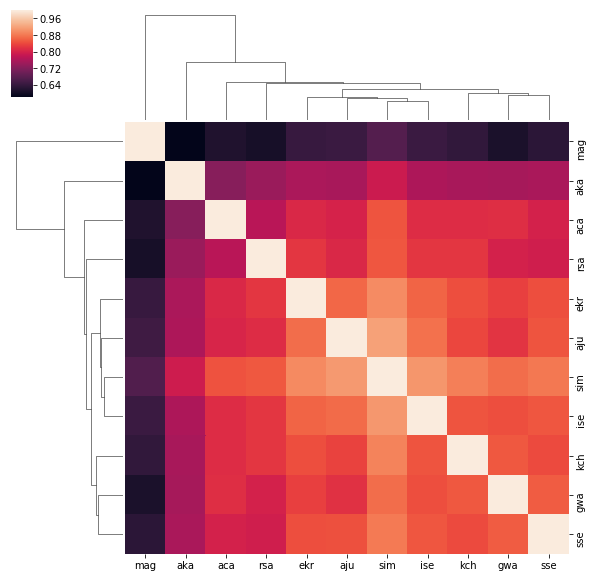

In [153]:
cl_irr = sb.clustermap(mean, method='complete')

### Preop and Postop Data Collection

Comparison for region wt: 
      Preop Mean  Postop Mean  Difference  Preop STDEV  Postop STDEV
aca    0.765267     0.743135   -0.022132     0.170562      0.220961
aju    0.809195     0.782751   -0.026443     0.178123      0.159476
aka    0.725190     0.689845   -0.035346     0.200904      0.201113
ekr    0.791954     0.755778   -0.036177     0.183028      0.193444
gwa    0.754774     0.738660   -0.016114     0.215637      0.209099
ise    0.797998     0.770322   -0.027676     0.206555      0.195910
kch    0.781317     0.747090   -0.034227     0.194565      0.201669
mag    0.653261     0.606626   -0.046635     0.301828      0.282237
mav    0.806910     0.785955   -0.020956     0.188321      0.174050
rsa    0.758902     0.729388   -0.029514     0.208403      0.223253
sim    0.808807     0.785775   -0.023032     0.186760      0.167698
sse    0.751320     0.743279   -0.008041     0.230218      0.202832

Mean difference: -0.027190952273770507

Mean difference stdev: 0.010234433376314227


NameError: name 'tccomp' is not defined

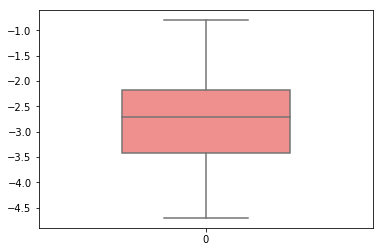

In [154]:
#comparison of the mean values for pre- and post-operative scans
comp = pandas.concat([preop.mean(), postop.mean(), (postop.mean()- preop.mean()), preop.std(), postop.std()], axis=1, sort=True)
newname = {0:'Preop Mean', 
           1:'Postop Mean',
           2:'Difference',
           3: 'Preop STDEV',
           4: 'Postop STDEV'
          }
comp = comp.rename(columns=newname)
print('Comparison for region ' + met + ': \n', comp)
print('\nMean difference: ' + str(comp['Difference'].mean()))
print('\nMean difference stdev: ' + str(comp['Difference'].std()))
comp = comp.round(decimals=3)*100
tex = comp.to_latex()
with open('textable-'+met+'.txt', 'w') as f: 
    f.write(tex)
prepostplot = sb.boxplot(data=comp['Difference'], width=0.5, palette='spring')
# assemble comprehensive table
if met == 'wt':
    wtcomp = comp.mean()
if met == 'tc':
    tccomp = comp.mean()
if met == 'at':
    atcomp = comp.mean()
    
compressed = pandas.concat([wtcomp, tccomp, atcomp], axis=1, sort=False)
compressed = compressed.rename(columns={0: 'Whole Tumor', 1:'Tumor Core', 2:'Active Tumor'})
compressed = compressed.round(decimals=1)
print(compressed)
tex2 = compressed.to_latex()
with open('textable-complete.txt', 'w') as f: 
    f.write(tex2)

In [155]:
#sort the indices by their mean value and reorder the data frame for descending plotting
m = data.mean()
m_sorted = m.sort_values(ascending=False)
print('Mean values sorted:')
pprint(m_sorted)
print('\nMedian sorted:')
pprint(data.median().sort_values(ascending=False))
print('\nStandard deviation sorted:')
pprint(data.std().sort_values(ascending=True))
indices = m_sorted.keys()
# order dataframe by mean
indices = indices.tolist()
wt_ordered = data[indices]

Mean values sorted:
sim    0.798195
mav    0.797255
aju    0.797011
ise    0.785247
ekr    0.775286
kch    0.765547
aca    0.755070
sse    0.747616
gwa    0.747350
rsa    0.745304
aka    0.708905
mag    0.631775
dtype: float64

Median sorted:
sim    0.861112
ise    0.858494
aju    0.856785
mav    0.855012
ekr    0.844004
kch    0.825068
sse    0.820918
aca    0.813874
rsa    0.813734
gwa    0.811814
aka    0.758393
mag    0.723017
dtype: float64

Standard deviation sorted:
aju    0.169861
sim    0.178141
mav    0.181714
ekr    0.188270
aca    0.195182
kch    0.198085
aka    0.201247
ise    0.201668
gwa    0.212245
rsa    0.215304
sse    0.217502
mag    0.293129
dtype: float64


In [156]:
# export all metrics to a table 
metrics = pandas.concat([m_sorted, data.median(), data.std()], axis=1, sort=True)
newname = {0:'Mean', 
           1:'Median',
           2:'Std-Dev'}
metrics = metrics.rename(columns=newname)
# round the values - who needs 8 decimals for such scores?!
metrics = metrics.round(decimals=3)
print(metrics)
metrics.to_csv('tables/'+met+'_table.csv')

      Mean  Median  Std-Dev
aca  0.755   0.814    0.195
aju  0.797   0.857    0.170
aka  0.709   0.758    0.201
ekr  0.775   0.844    0.188
gwa  0.747   0.812    0.212
ise  0.785   0.858    0.202
kch  0.766   0.825    0.198
mag  0.632   0.723    0.293
mav  0.797   0.855    0.182
rsa  0.745   0.814    0.215
sim  0.798   0.861    0.178
sse  0.748   0.821    0.218


# Fancy Boxplots for DICE Scores

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

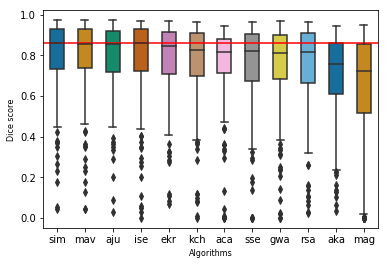

In [157]:
# fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
#wt_ordered.drop(['patient'], axis=1, inplace=True)
bplot = sb.boxplot(data=wt_ordered, 
                 width=0.5,
                 palette="colorblind")
#bplot.axes.set_title('DICE Scores for whole tumor', fontsize=16)
bplot.set_xlabel('Algorithms', fontsize=8)
bplot.set_ylabel('Dice score', fontsize=8)
#plot a horizontal line at the max mean location
bplot.hlines(np.max(data.median()), -100, 1000, colors='r')
#save the plot
bplot.figure.savefig('plots/'+met+'_fullplot_thresh3.png', format=form, dpi=res)

Text(0, 0.5, 'Dice score')

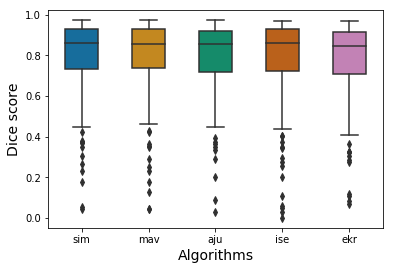

In [158]:
results = np.split(wt_ordered, [5], axis=1)
bplot1 = sb.boxplot(data=results[0], 
                 width=0.5,
                 palette="colorblind")
#bplot.axes.set_title('DICE Scores for whole tumor', fontsize=16)
bplot1.set_xlabel('Algorithms', fontsize=14)
bplot1.set_ylabel('Dice score', fontsize=14)

Text(0, 0.5, 'Dice score')

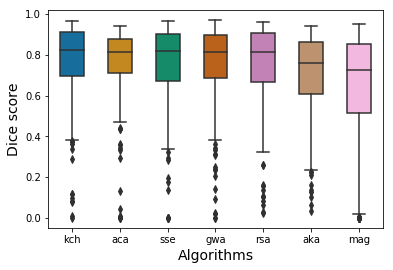

In [159]:
bplot2 = sb.boxplot(data=results[1], 
                 width=0.5,
                 palette="colorblind")
#bplot.axes.set_title('DICE Scores for whole tumor', fontsize=16)
bplot2.set_xlabel('Algorithms', fontsize=14)
bplot2.set_ylabel('Dice score', fontsize=14)

In [160]:
#save all of it
#bplot1.figure.savefig(met+'_boxplot1.png', format=form, dpi=res)
#bplot2.figure.savefig(met+'_boxplot2.png', format=form, dpi=res)
#cl.savefig('clustermap.png', format=form, dpi=res)

## Cluster Map

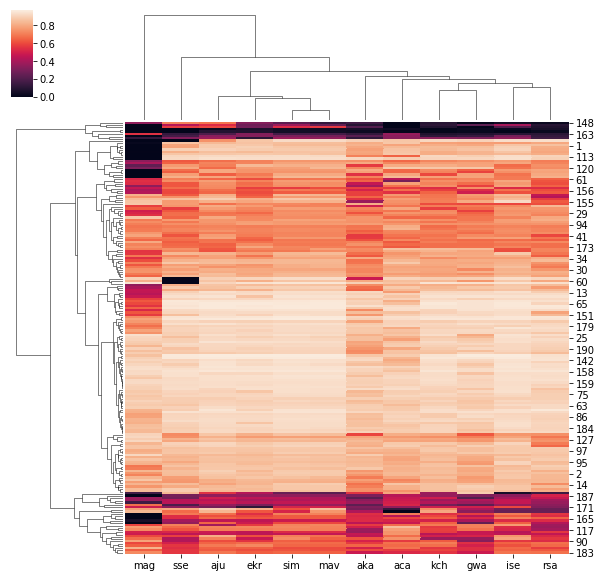

In [161]:
cl = sb.clustermap(wt_ordered, method='complete')
#cl.savefig('clustermap.png', format=form, dpi=res)

## Compound table for DICE

In [162]:
data = pandas.read_csv('wt_dice_scores.csv')
wt_scores = preprocessor(data, 'whole')
tc_scores = preprocessor(pandas.read_csv('tc_dice_scores.csv'), 'core')
at_scores = preprocessor(pandas.read_csv('at_dice_scores.csv'), 'active')
wt_scores.describe()

FileNotFoundError: File b'fixed_data/whole_clean.csv' does not exist

In [163]:
wt_m = wt_scores.median()
tc_m = tc_scores.median()
at_m = at_scores.median()
bobby = pandas.concat([wt_m, tc_m, at_m], axis=1, sort=True)
newkidz = {
    0 : 'WT',
    1 : 'TC',
    2 : 'AT'
}
bobby = bobby.rename(columns=newkidz)
bobby = bobby.round(decimals=3)*100
bobby.to_csv('tables/concisedice.csv')

NameError: name 'wt_scores' is not defined

## Specificity and Sensitivity Plotting

In [164]:
# load data 
wt_spec = preprocessor(pandas.read_csv('specificity/wt_scores.csv'), 'wt-spec')
tc_spec = preprocessor(pandas.read_csv('specificity/tc_scores.csv'), 'tc-spec')
at_spec = preprocessor(pandas.read_csv('specificity/at_scores.csv'), 'at-spec')

wt_sens = preprocessor(pandas.read_csv('sensitivity/wt_scores.csv'), 'wt-sens')
tc_sens = preprocessor(pandas.read_csv('sensitivity/tc_scores.csv'), 'tc-sens')
at_sens = preprocessor(pandas.read_csv('sensitivity/at_scores.csv'), 'at-sens')


FileNotFoundError: File b'fixed_data/wt-spec_clean.csv' does not exist

In [165]:
wt_spec.describe()

NameError: name 'wt_spec' is not defined

In [166]:
wt_sens.describe()

NameError: name 'wt_sens' is not defined

In [167]:
# create Series for mean of specificity and sensitivity
wtsp_m = wt_spec.mean().round(decimals=3)
wtse_m = wt_sens.mean().round(decimals=3)
wtse_m

NameError: name 'wt_spec' is not defined

In [168]:
# assemble Series to a single dataframe and rename the columns
wt_plt = pandas.concat([wtsp_m, wtse_m], axis=1, sort=True)
wt_plt = wt_plt.rename({0: 'Specificity', 1:'Sensitivity'}, axis=1)
# define some colors for the plots
colors = ['red','green','blue', 'aqua','gold','fuchsia', 'indigo','lavender','orange', 'sienna','teal','plum']
# plot sensitivity vs specificity 
ax = wt_plt.plot.scatter(x=0, y=1, c=colors, marker='s')
for i, txt in enumerate(wt_plt.index):
    ax.annotate(txt, (wt_plt.Specificity.iat[i],wt_plt.Sensitivity.iat[i]))
ax.grid(True)
ax.set_title('Whole Tumor Specificity vs Sensitivity')
ax.figure.savefig('wt_sesp.png', format=form, dpi=res)
#ax.annotate('aca', wt_plt[0][0], wt_plt[1][0])

NameError: name 'wtsp_m' is not defined

In [169]:
tcsp_m = tc_spec.mean().round(decimals=3)
tcse_m = tc_sens.mean().round(decimals=3)
tc_plt = pandas.concat([tcsp_m, tcse_m], axis=1, sort=True)
tc_plt = tc_plt.rename({0: 'Specificity', 1:'Sensitivity'}, axis=1)
colors = ['red','green','blue', 'aqua','gold','fuchsia', 'indigo','lavender','orange', 'sienna','teal','plum']
ax = tc_plt.plot.scatter(x=0, y=1, c=colors, marker='s')
for i, txt in enumerate(tc_plt.index):
    ax.annotate(txt, (tc_plt.Specificity.iat[i],tc_plt.Sensitivity.iat[i]))
ax.grid(True)
ax.set_title('Tumor Core Specificity vs Sensitivity')
ax.figure.savefig('tc_sesp.png', format=form, dpi=res)

NameError: name 'tc_spec' is not defined

In [170]:
atsp_m = at_spec.mean().round(decimals=3)
atse_m = at_sens.mean().round(decimals=3)
at_plt = pandas.concat([atsp_m, atse_m], axis=1, sort=True)
at_plt = at_plt.rename({0: 'Specificity', 1:'Sensitivity'}, axis=1)
colors = ['red','green','blue', 'aqua','gold','fuchsia', 'indigo','lavender','orange', 'sienna','teal','plum']
ax = at_plt.plot.scatter(x=0, y=1, c=colors, marker='s')
for i, txt in enumerate(at_plt.index):
    ax.annotate(txt, (at_plt.Specificity.iat[i],at_plt.Sensitivity.iat[i]))
ax.grid(True)
ax.set_title('Active Tumor Specificity vs Sensitivity')
ax.figure.savefig('at_sesp.png', format=form, dpi=res)

NameError: name 'at_spec' is not defined

In [171]:
#once again but with MEDIAN 
atsp_m = at_spec.median().round(decimals=3)
atse_m = at_sens.median().round(decimals=3)
at_plt = pandas.concat([atsp_m, atse_m], axis=1, sort=True)
at_plt = at_plt.rename({0: 'Specificity', 1:'Sensitivity'}, axis=1)
colors = ['red','green','blue', 'aqua','gold','fuchsia', 'indigo','lavender','orange', 'sienna','teal','plum']
ax = at_plt.plot.scatter(x=0, y=1, c=colors, marker='s')
for i, txt in enumerate(at_plt.index):
    ax.annotate(txt, (at_plt.Specificity.iat[i],at_plt.Sensitivity.iat[i]))
ax.grid(True)
ax.set_title('Active Tumor Specificity vs Sensitivity')

NameError: name 'at_spec' is not defined

In [172]:
sens = at_plt.plot(y='Sensitivity', kind='bar')

NameError: name 'at_plt' is not defined